## HPI Electricity

This notebook will extract typical profiles for use as input for the coupled co-simulation with CitySim

In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline 

In [43]:
sns.set_style("whitegrid")

In [7]:
workingdir = "/Users/Clayton/Dropbox/03-ETH/98-UMEM/RawDataAnalysis/"

In [8]:
# os.chdir(workingdir)

In [9]:
df = pd.read_csv(workingdir+"aggset2_QW/HPI_QW.csv", index_col="Date Time", parse_dates=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 70200 entries, 2006-01-07 01:00:00 to 2014-01-10 00:00:00
Data columns (total 13 columns):
HPIMEL01QW_A [kWh]    70034 non-null float64
HPIMEL31QW_A [kWh]    70034 non-null float64
HPIMEL32QW_A [kWh]    70015 non-null float64
HPIMEL33QW_A [kWh]    70034 non-null float64
HPIMEL34QW_A [kWh]    70034 non-null float64
HPIMEL35QW_A [kWh]    16833 non-null float64
HPIMEL40QW_A [kWh]    69901 non-null float64
HPIMEL50QW_A [kWh]    70024 non-null float64
HPIMEL60QW_A [kWh]    69906 non-null float64
HPIMEL70QW_A [kWh]    70034 non-null float64
HPIMHE01QW_A [kWh]    70025 non-null float64
HPIMHE66QW_A [kWh]    70021 non-null float64
HPIMKA01QW_A [kWh]    69906 non-null float64
dtypes: float64(13)
memory usage: 7.5 MB


In [11]:
point = "HPIMEL01QW_A [kWh]"

In [12]:
df_QW = pd.DataFrame(df[point].truncate(before='2013',after='2014'))

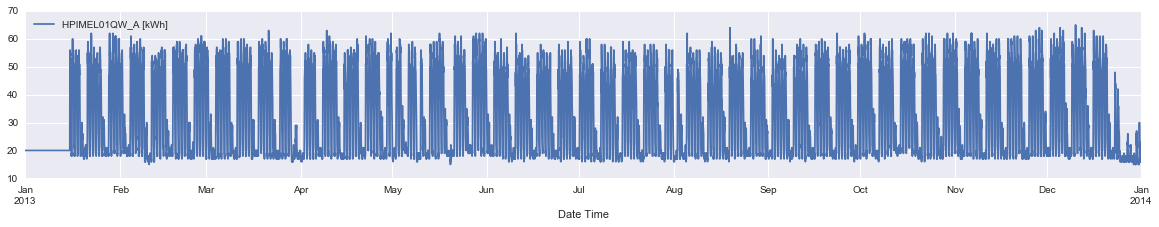

In [13]:
df_QW.plot(figsize=(20,3));

## Convert to SAX

In [14]:
df = df_QW.dropna()

In [15]:
#df.head()

In [16]:
df['Date'] = df.index.map(lambda t: t.date())
df['Time'] = df.index.map(lambda t: t.time())

/Users/Clayton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/Clayton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [17]:
df_pivot = pd.pivot_table(df, values=point, index='Date', columns='Time')

In [18]:
a = 3
w = '4h'

In [19]:
from scipy.stats import norm
import numpy as np
import string

In [20]:
def discretizer(row, breakpoints):
    return np.where(breakpoints > float(row))[0][0]

def stringizer(row):
    return ''.join(string.ascii_letters[int(row['step'])])

def adddate(df):
    df['Date'] = df.index.map(lambda t: t.date())
    df['Time'] = df.index.map(lambda t: t.time())
    return df

def SAXizer(df, symbol_count, breakfreq):
    x = df.fillna(method='ffill')
    y = (x - x.mean()) / x.std()
    z = pd.DataFrame(y.resample(breakfreq).dropna())
    z.columns = ["numbers"]
    breakpoints = norm.ppf(np.linspace(1./symbol_count, 1-1./symbol_count, symbol_count-1))
    breakpoints = np.concatenate((breakpoints, np.array([np.Inf])))
    
    z['step'] = z.apply(discretizer, axis=1, args=[breakpoints])
    z['letter'] = z.apply(stringizer, axis=1)
    z = adddate(z)
    zpivot = z.pivot(index='Date', columns='Time', values='letter')
    zpivot = z.pivot(index='Date', columns='Time', values='letter')
    
    SAXstrings = zpivot.dropna().sum(axis=1)
    
    return zpivot.dropna(), SAXstrings

In [21]:
df_forSAX = df[point]
zpivot, SAXstrings = SAXizer(df_forSAX, a, w)

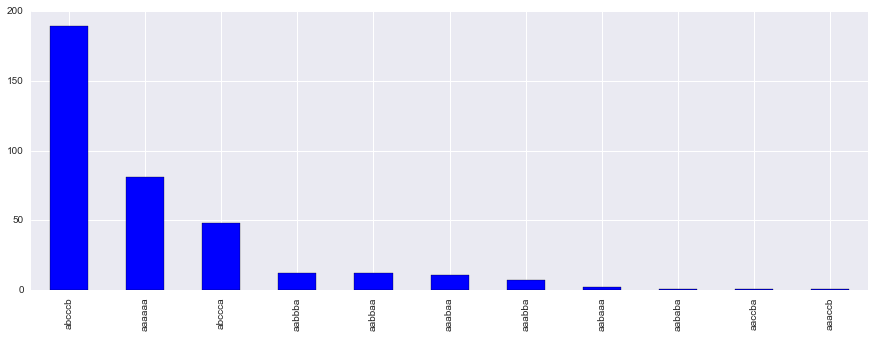

In [22]:
patterncount = SAXstrings.value_counts()
patterncount.plot(kind='bar', figsize=(15,5));

In [23]:
binsizethreshold = 0.02
motifs = patterncount[(patterncount > patterncount.sum() * binsizethreshold)]
motifs

abcccb    189
aaaaaa     81
abccca     48
aabbba     12
aabbaa     12
aaabaa     11
dtype: int64

In [24]:
discords = patterncount[(patterncount < patterncount.sum() * binsizethreshold)]
discords.head()

aaabba    7
aabaaa    2
aababa    1
aaccba    1
aaaccb    1
dtype: int64

In [25]:
df_RawAndSAX = pd.concat([df_pivot, pd.DataFrame(SAXstrings, columns=['SAXstring'])], axis=1)

In [26]:
motifdata = df_RawAndSAX[df_RawAndSAX.SAXstring.isin(list(motifs.index))]

#Cluster!

In [27]:
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt


In [28]:
# df = motifdata.drop(['SAXstring'], axis=1)

In [29]:
df_pivot.head()

Time,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,...,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,20,20,20,20,20,20,20,20,20,20,...,20,20,20,20,20,20,20,20,20,20
2013-01-02,20,20,20,20,20,20,20,20,20,20,...,20,20,20,20,20,20,20,20,20,20
2013-01-03,20,20,20,20,20,20,20,20,20,20,...,20,20,20,20,20,20,20,20,20,20
2013-01-04,20,20,20,20,20,20,20,20,20,20,...,20,20,20,20,20,20,20,20,20,20
2013-01-05,20,20,20,20,20,20,20,20,20,20,...,20,20,20,20,20,20,20,20,20,20


In [30]:
df = df_pivot

In [31]:
def timestampcombine_parse(date,time):
    #timestampstring = date+" "+time
#     date = datetime.strptime(date, "%Y-%M-%d")
#     time = datetime.strptime(time, "%H:%M:%S").time()
    pydatetime = datetime.combine(date, time)

    #pydatetime = pydatetime.replace(tzinfo=pytz.UTC)
    #return pydatetime.astimezone(singaporezone).replace(tzinfo=None)
    return pydatetime

In [32]:
df = df.T.unstack().reset_index()
df['timestampstring'] = map(timestampcombine_parse, df.Date, df.Time)
df.index = df.timestampstring
df = df.drop(['Date','Time','timestampstring'],axis=1)
df.columns = [point]
df = df.resample('H')

In [33]:
df.head()

,HPIMEL01QW_A [kWh]
timestampstring,
2013-01-01 00:00:00,20
2013-01-01 01:00:00,20
2013-01-01 02:00:00,20
2013-01-01 03:00:00,20
2013-01-01 04:00:00,20


In [34]:
from scipy.cluster.vq import kmeans, vq, whiten
from scipy.spatial.distance import cdist
from sklearn import metrics
import numpy as np

In [35]:
df_norm = (df - df.mean()) / (df.max() - df.min()) #normalized

df['Time'] = df.index.map(lambda t: t.time())
df['Date'] = df.index.map(lambda t: t.date())
df_norm['Time'] = df_norm.index.map(lambda t: t.time())
df_norm['Date'] = df_norm.index.map(lambda t: t.date())

In [36]:
dailyblocks = pd.pivot_table(df, values=point, index='Date', columns='Time', aggfunc='mean')
dailyblocks_norm = pd.pivot_table(df_norm, values=point, index='Date', columns='Time', aggfunc='mean')

In [37]:
dailyblocksmatrix_norm = np.matrix(dailyblocks_norm.dropna())
centers, _ = kmeans(dailyblocksmatrix_norm, 4, iter=10000)
cluster, _ = vq(dailyblocksmatrix_norm, centers)

In [38]:
clusterdf = pd.DataFrame(cluster, columns=['ClusterNo'])

In [39]:
dailyclusters = pd.concat([dailyblocks.dropna().reset_index(), clusterdf], axis=1) 

In [40]:
x = dailyclusters.groupby('ClusterNo').mean().sum(axis=1).order()
x = pd.DataFrame(x.reset_index())
x['ClusterNo2'] = x.index
x = x.set_index('ClusterNo')
x = x.drop([0], axis=1)
dailyclusters = dailyclusters.merge(x, how='outer', left_on='ClusterNo', right_index=True)

/Users/Clayton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: order is deprecated, use sort_values(...)
  if __name__ == '__main__':


In [41]:
dailyclusters = dailyclusters.drop(['ClusterNo'],axis=1)
dailyclusters = dailyclusters.set_index(['ClusterNo2','Date']).T.sort()

/Users/Clayton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(....) is deprecated, use sort_index(.....)
  from ipykernel import kernelapp as app


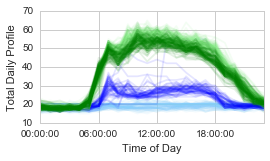

In [44]:
clusterlist = list(dailyclusters.columns.get_level_values(0).unique())
matplotlib.rcParams['figure.figsize'] = 4,2

styles2 = ['LightSkyBlue', 'b','LightGreen', 'g','LightCoral','r','SandyBrown','Orange','Plum','Purple','Gold','b']
fig, ax = plt.subplots()
for col, style in zip(clusterlist, styles2):
    dailyclusters[col].plot(ax=ax, legend=False, style=style, alpha=0.1, xticks=np.arange(0, 86400, 21600))

ax.set_ylabel('Total Daily Profile')
ax.set_xlabel('Time of Day')
plt.savefig("clusters_total_overlaid_profiles.pdf")

In [48]:
def ClusterUnstacker(df):
    df = df.unstack().reset_index()
    df['timestampstring'] = map(timestampcombine, df.Date, df.Time)
    df = df.dropna()
    return df

In [49]:
def timestampcombine(date,time):
    pydatetime = datetime.combine(date, time)
    #pydatetime = pydatetime.replace(tzinfo=pytz.UTC)
    #return pydatetime.astimezone(singaporezone).replace(tzinfo=None)
    return pydatetime

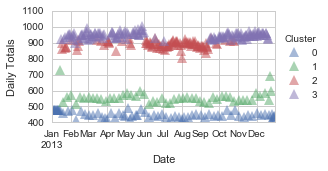

In [50]:
dfclusterunstacked = ClusterUnstacker(dailyclusters)
dfclusterunstackedpivoted = pd.pivot_table(dfclusterunstacked, values=0, index='timestampstring', columns='ClusterNo2')

clusteravgplot = dfclusterunstackedpivoted.resample('D', how=np.sum).plot(style="^",markersize=10, alpha=0.5)
clusteravgplot.set_ylabel('Daily Totals')
clusteravgplot.set_xlabel('Date')
clusteravgplot.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Cluster')

plt.savefig("clusters_overtime.pdf")

In [51]:
dailyclusters.head()

ClusterNo2          0                                                         \
Date       2013-01-01 2013-01-02 2013-01-03 2013-01-04 2013-01-05 2013-01-06   
Time                                                                           
00:00:00           20         20         20         20         20         20   
01:00:00           20         20         20         20         20         20   
02:00:00           20         20         20         20         20         20   
03:00:00           20         20         20         20         20         20   
04:00:00           20         20         20         20         20         20   

ClusterNo2                                                ...              2  \
Date       2013-01-07 2013-01-08 2013-01-09 2013-01-10    ...     2013-09-11   
Time                                                      ...                  
00:00:00           20         20         20         20    ...             18   
01:00:00           20         20         20         20    ...             18   
02:00:00           20         20         20         20    ...             18   
03:00:00           20         20         20         20    ...             17   
04:00:00           20         20         20         20    ...             18   

ClusterNo2                                                                    \
Date       2013-09-12 2013-09-13 2013-09-17 2013-09-26 2013-09-27 2013-10-11   
Time                                                                           
00:00:00           18         18         19         18         18         20   
01:00:00           18         17         19         17         17         20   
02:00:00           17         16         18         17         18         18   
03:00:00           18         18         18         19         18         20   
04:00:00           19         17         19         17         18         18   

ClusterNo2                                   
Date       2013-10-18 2013-10-24 2013-10-25  
Time                                         
00:00:00           19         17         18  
01:00:00           21         19         18  
02:00:00           18         18         18  
03:00:00           20         18         20  
04:00:00           19         18         17  

[5 rows x 364 columns]

In [52]:
calendar = dfclusterunstackedpivoted.resample('D', how=np.sum)
calendar.head()

ClusterNo2,0,1,2,3
timestampstring,,,,
2013-01-01,480,NaN,NaN,NaN
2013-01-02,480,NaN,NaN,NaN
2013-01-03,480,NaN,NaN,NaN
2013-01-04,480,NaN,NaN,NaN
2013-01-05,480,NaN,NaN,NaN


In [53]:
calendar.to_csv("calendar.csv")

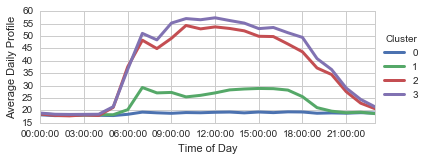

In [54]:
dfclusterunstackedpivoted['Time'] = dfclusterunstackedpivoted.index.map(lambda t: t.time())
dailyprofile = dfclusterunstackedpivoted.groupby('Time').mean().plot(figsize=(6,2),linewidth=3, xticks=np.arange(0, 86400, 10800))
dailyprofile.set_ylabel('Average Daily Profile')
dailyprofile.set_xlabel('Time of Day')
dailyprofile.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Cluster')
plt.savefig("clusters_averagedprofiles.pdf")

In [55]:
dfclusterunstackedpivoted.groupby('Time').max().max().max()

65.0

In [56]:
#dfclusterunstackedpivoted['Time'] = dfclusterunstackedpivoted.index.map(lambda t: t.time())
normalizedprofiles = dfclusterunstackedpivoted.groupby('Time').mean() / dfclusterunstackedpivoted.groupby('Time').max().max().max()

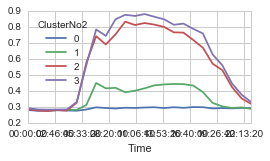

In [57]:
normalizedprofiles = normalizedprofiles.fillna(0)
normalizedprofiles.plot()

In [58]:
normalizedprofiles.to_csv("Schedules.csv")

In [59]:
def DayvsClusterMaker(df):
    df.index = df.timestampstring
    df['Weekday'] = df.index.map(lambda t: t.date().weekday())
    df['Date'] = df.index.map(lambda t: t.date())
    df['Time'] = df.index.map(lambda t: t.time())
    DayVsCluster = df.resample('D').reset_index(drop=True)
    DayVsCluster = pd.pivot_table(DayVsCluster, values=0, index='ClusterNo2', columns='Weekday', aggfunc='count')
    DayVsCluster.columns = ['Mon','Tue','Wed','Thur','Fri','Sat','Sun']
    return DayVsCluster.T

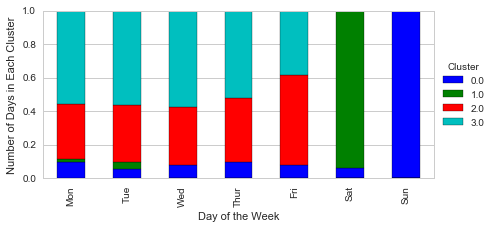

In [60]:
DayVsCluster = DayvsClusterMaker(dfclusterunstacked)
DayVsCluster = DayVsCluster.T/DayVsCluster.T.sum()
DayVsCluster = DayVsCluster.T
DayVsClusterplot1 = DayVsCluster.plot(figsize=(7,3), kind='bar', stacked=True)
DayVsClusterplot1.set_ylabel('Number of Days in Each Cluster')
DayVsClusterplot1.set_xlabel('Day of the Week')
DayVsClusterplot1.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Cluster')
plt.savefig("clusters_dailybreakdown.pdf")

In [61]:
DayVsCluster

ClusterNo2,0.0,1.0,2.0,3.0
Mon,0.096154,0.019231,0.326923,0.557692
Tue,0.056604,0.037736,0.339623,0.566038
Wed,0.076923,NaN,0.346154,0.576923
Thur,0.096154,NaN,0.384615,0.519231
Fri,0.076923,NaN,0.538462,0.384615
Sat,0.057692,0.942308,NaN,NaN
Sun,1.000000,NaN,NaN,NaN


##Create Graphics for JBPS Paper

First load the resultant data from the analysis so no need to rerun:

In [62]:
normalizedprofiles = pd.read_csv("Schedules.csv", index_col='Time')

In [63]:
normalizedprofiles.head()

,0,1,2,3
Time,,,,
00:00:00,0.280205,0.287574,0.285301,0.291290
01:00:00,0.275282,0.281065,0.276618,0.283824
02:00:00,0.276103,0.278698,0.273877,0.282692
03:00:00,0.278974,0.279290,0.279360,0.283145
04:00:00,0.277333,0.281361,0.276314,0.283824


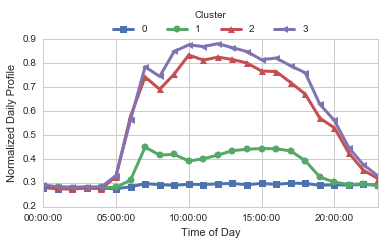

In [67]:
styles1 = ['s-','o-','^-','<-','->','-H']
dailyprofile = normalizedprofiles.plot(figsize=(6,3),linewidth=3,style=styles1)
dailyprofile.set_ylabel('Normalized Daily Profile')
dailyprofile.set_xlabel('Time of Day')
dailyprofile.legend(loc='center', bbox_to_anchor=(0.5, 1.1), title='Cluster', ncol=4)
plt.savefig("clusters_averagedprofiles_normalized.pdf")

### The Cal-Heatmap setup

In [56]:
calendar = pd.read_csv("calendar.csv", index_col='timestampstring', parse_dates=True)

In [57]:
#calendar.fillna(0).dropna(how="all").info()

In [58]:
import time

In [59]:
calendar['epochtime'] = calendar.index.map(lambda x: int(time.mktime(x.timetuple())))
calendar.index = calendar.epochtime

In [60]:
calendar.head()

,0,1,2,3,epochtime
epochtime,,,,,
1356994800,480,NaN,NaN,NaN,1356994800
1357081200,480,NaN,NaN,NaN,1357081200
1357167600,480,NaN,NaN,NaN,1357167600
1357254000,480,NaN,NaN,NaN,1357254000
1357340400,480,NaN,NaN,NaN,1357340400


In [61]:
calendar = calendar.drop(['epochtime'], axis=1)

In [62]:
calendar.head()

,0,1,2,3
epochtime,,,,
1356994800,480,NaN,NaN,NaN
1357081200,480,NaN,NaN,NaN
1357167600,480,NaN,NaN,NaN
1357254000,480,NaN,NaN,NaN
1357340400,480,NaN,NaN,NaN


In [63]:
cal_heatmap = calendar.unstack().dropna().reset_index()

In [64]:
cal_heatmap.head()

,level_0,epochtime,0
0,0,1356994800,480
1,0,1357081200,480
2,0,1357167600,480
3,0,1357254000,480
4,0,1357340400,480


In [65]:
cal_heatmap.index = cal_heatmap.epochtime

In [66]:
cal_heatmap.head()

,level_0,epochtime,0
epochtime,,,
1356994800,0,1356994800,480
1357081200,0,1357081200,480
1357167600,0,1357167600,480
1357254000,0,1357254000,480
1357340400,0,1357340400,480


In [67]:
cal_heatmap = cal_heatmap.drop(['epochtime',0], axis=1)

In [68]:
cal_heatmap = cal_heatmap.sort()

In [69]:
cal_heatmap.level_0 = cal_heatmap.level_0.astype("float")

In [70]:
cal_heatmap.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364 entries, 1356994800 to 1388444400
Data columns (total 1 columns):
level_0    364 non-null float64
dtypes: float64(1)
memory usage: 5.7 KB


In [71]:
cal_heatmap.head()

,level_0
epochtime,
1356994800,0
1357081200,0
1357167600,0
1357254000,0
1357340400,0


In [72]:
cal_heatmap = cal_heatmap+1

In [73]:
cal_heatmap.head()

,level_0
epochtime,
1356994800,1
1357081200,1
1357167600,1
1357254000,1
1357340400,1


In [74]:
cal_heatmap.level_0.to_json("hpi_cal_heatmap.json")

In [75]:
x = sns.color_palette()

In [76]:
import matplotlib.colors as colors

In [77]:
for color in x:
    print colors.rgb2hex(color)

#4c72b0
#55a868
#c44e52
#8172b2
#ccb974
#64b5cd
